# Regime-Aware Factor Rotation Strategy Using Machine Learning 
**Name: Gaganjot Kaur**


**Overview:**
This notebook develops and backtests an Regime-Aware Factor Rotation strategy. The central premise is that no single investment factor—such as value or momentum—excels in every market condition. Instead, this strategy uses machine learning to first detect the current “market regime,” then dynamically selects the factor historically shown to outperform in that regime. The goal is to generate stronger, more consistent risk-adjusted returns than a static factor portfolio.

**Key Workflow:**
Data Ingestion → EDA & Data Quality Checks → Feature Engineering → Regime Labelling → Two-Stage Process → ML Training → Walk-Forward Backtesting → Performance Analysis
1. Setup & Data Ingestion 
2. Exploratory Data Analysis (EDA) & Data Quality Checks
3. Feature Engineering
4. Volatility-Based Market Regime Labelling
5. Machine Learning Model Training & Walk-Forward Backtesting
6. Performance Analysis
7. Conclusion

## 1. Setup & Data Ingestion 

I have selected seven well-established factor ETFs representing distinct investment styles: Value (VTV), Momentum (MTUM), Quality (QUAL), Low Volatility (SPLV), Size (IJR), Dividend Growth (VIG), and Growth (VUG). SPY serves as the benchmark for relative performance measurement. The 10-year window (2015-2025) spans multiple market regimes including the COVID crash, recovery, and inflationary periods—ideal for testing regime-adaptive strategies.

In [7]:
# 1. Setup & Data Ingestion 

# 1.1 Import Libraries
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.linear_model import LogisticRegression
from statsmodels.tsa.stattools import adfuller, kpss
from cvxopt import solvers
from IPython.display import display
from sklearn.base import clone
import warnings
warnings.filterwarnings('ignore')
solvers.options['show_progress'] = False
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.float_format', '{:.4f}'.format)


# 1.2 Data Ingestion

# Download historical data for factor etfs and the benchmark (SPY).
factor_etfs = {
    'Value': 'VTV',        # Large-Cap Value
    'Momentum': 'MTUM',    # Momentum
    'Quality': 'QUAL',     # Quality
    'LowVol': 'SPLV',      # Low Volatility
    'Size': 'IJR',         # Small-Cap (S&P SmallCap 600) - Size factor
    'Dividend': 'VIG',     # Dividend Appreciation - Yield/Dividend factor
    'Growth': 'VUG',       # Growth - Growth factor
}

benchmark = 'SPY'
tickers = list(factor_etfs.values()) + [benchmark]
print("Downloading data for:", tickers)


# 1.3 Set Data Range

# analysis period: 10 years
end_date = '2025-12-01'
start_date = '2015-12-01'

# Download adjusted close prices. Using `auto_adjust=True` ensures dividends are accounted for.
raw_data = yf.download(tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = raw_data['Close'].dropna(how='any')

# Compute simple monthly returns for portfolio construction and analysis.
monthly_prices = prices.resample('M').last()
monthly_returns = monthly_prices.pct_change().dropna()

print(f"Data range: {monthly_returns.index[0].date()} to {monthly_returns.index[-1].date()}")
print(f"Total months of return data: {len(monthly_returns)}")


Data range: 2016-01-31 to 2025-11-30
Total months of return data: 119


## 2. Exploratory Data Analysis (EDA) & Data Quality Checks

In data statistical analysis, Growth (VUG) shows the highest mean return (1.50% monthly) but also highest volatility (5.18%). Low Volatility (SPLV) lives up to its name with the lowest volatility (3.62%) but also the lowest returns (0.78%). The Jarque-Bera tests confirm most factors reject normality (p < 0.05), justifying the use of non-parametric ML models like Random Forests. Outliers are present but limited, suggesting reasonable data quality.

The histograms visually confirm the fundamental risk-return tradeoff. VUG (Growth) offers the highest mean return (1.50% monthly) but with the widest distribution (σ=5.15%), indicating greater volatility. Conversely, SPLV (Low Volatility) provides the most stable returns (tightest distribution, σ=3.61%) but with the lowest mean return (0.78%). While all distributions approximate normality, subtle differences in skewness and kurtosis are visible. Defensive factors (SPLV, VIG) show slightly more peaked distributions, while cyclical factors (IJR, VUG) exhibit fatter tails—important for risk modeling and ML feature engineering. The varying distribution widths across factors suggest different volatility regimes may affect factors disproportionately. This validates our regime-based ML approach, as factors likely require different selection logic in high vs. low volatility environments. The boxplot confirms there are outlier in monthly returns for all factors.

The hierarchical dendrogram identifies three distinct factor clusters that align with fundamental investment styles: (1) Growth/Momentum (VUG/MTUM), (2) Quality/Dividend/Core (QUAL/VIG/SPY), and (3) Value (VTV). This validates our factor selection capturing diverse yet coherent investment approaches. Near-perfect correlations (0.98 between SPY and QUAL) suggest limited standalone diversification value within the quality/dividend cluster. The strategy adapts by targeting factors that behave differently under various regimes—a condition that is not invalidated by high correlation. SPLV (Low Volatility) and IJR (Small Cap) emerge as relative outliers, offering true diversification potential. Their moderate correlations (0.64-0.73 range with other factors) indicate they capture unique risk premia—valuable for the two-stage selection process. The clustering analysis validates the regime-adaptive framework by demonstrating its practical application: integrating defensive outliers (SPLV) with core holdings in high-volatility regimes and overweighting growth-oriented clusters (VUG/MTUM) during expansions. This confirms the portfolio is structured around return drivers that are distinct but not orthogonal.

**Stationarity**:
ML models assume stationarity for consistent relationships. Both ADF (rejects non-stationarity) and KPSS (accepts stationarity) tests confirm all factor returns are stationary. Stationarity ensures our ML models learn stable relationships rather than spurious time trends.

**Autocorrelation**: 
Autocorrelation quantifies how a value in a time series is related to its past values. Positive autocorrelation suggests momentum (returns follow prior returns), while negative values suggest mean reversion (returns reverse). The shaded pink region represents a confidence interval. Autocorrelation values are mostly within the confidence interval, indicating no statistical significance or mean-reversion patterns.

**Volatility**: 
The 2020 COVID spike and 2022 inflation shock create clear volatility regimes where all factors respond but with varying magnitudes. SPLV's defensive character is confirmed, it shows the smallest volatility spikes during crises. The cross-sectional volatility ordering reveals a natural risk spectrum: IJR (small-cap, highest risk) → VUG/MTUM (growth/momentum) → core factors → SPLV (lowest risk). This hierarchy matches factor theory and informs risk management that high-volatility factors may need position sizing adjustments.



Statistics for Factor ETFs:


,Mean,Median,Std,Skewness,Kurtosis,Min,Max,IQR,Outlier_Count,Outlier_Pct,JB_Statistic,JB_p-value
IJR,0.0097,0.0137,0.0600,-0.3127,1.4928,-0.2255,0.1822,0.0675,2.0000,1.6807,11.3451,0.0034
MTUM,0.0125,0.0159,0.0473,-0.2878,0.4462,-0.1268,0.1255,0.0543,4.0000,3.3613,2.3087,0.3153
QUAL,0.0117,0.0138,0.0448,-0.4566,0.3427,-0.1139,0.1228,0.0469,8.0000,6.7227,4.4157,0.1099
SPLV,0.0078,0.0094,0.0362,-0.6279,1.5270,-0.1312,0.0971,0.0386,5.0000,4.2017,17.5297,0.0002
SPY,0.0125,0.0185,0.0437,-0.5048,0.6804,-0.1249,0.1270,0.0458,8.0000,6.7227,6.7255,0.0346
VIG,0.0112,0.0158,0.0388,-0.3676,0.3215,-0.0959,0.1004,0.0456,4.0000,3.3613,2.9435,0.2295
VTV,0.0102,0.0153,0.0424,-0.4730,1.5411,-0.1483,0.1276,0.0466,6.0000,5.0420,14.4236,0.0007
VUG,0.0150,0.0201,0.0518,-0.3440,0.3640,-0.1288,0.1508,0.0556,6.0000,5.0420,2.7315,0.2552


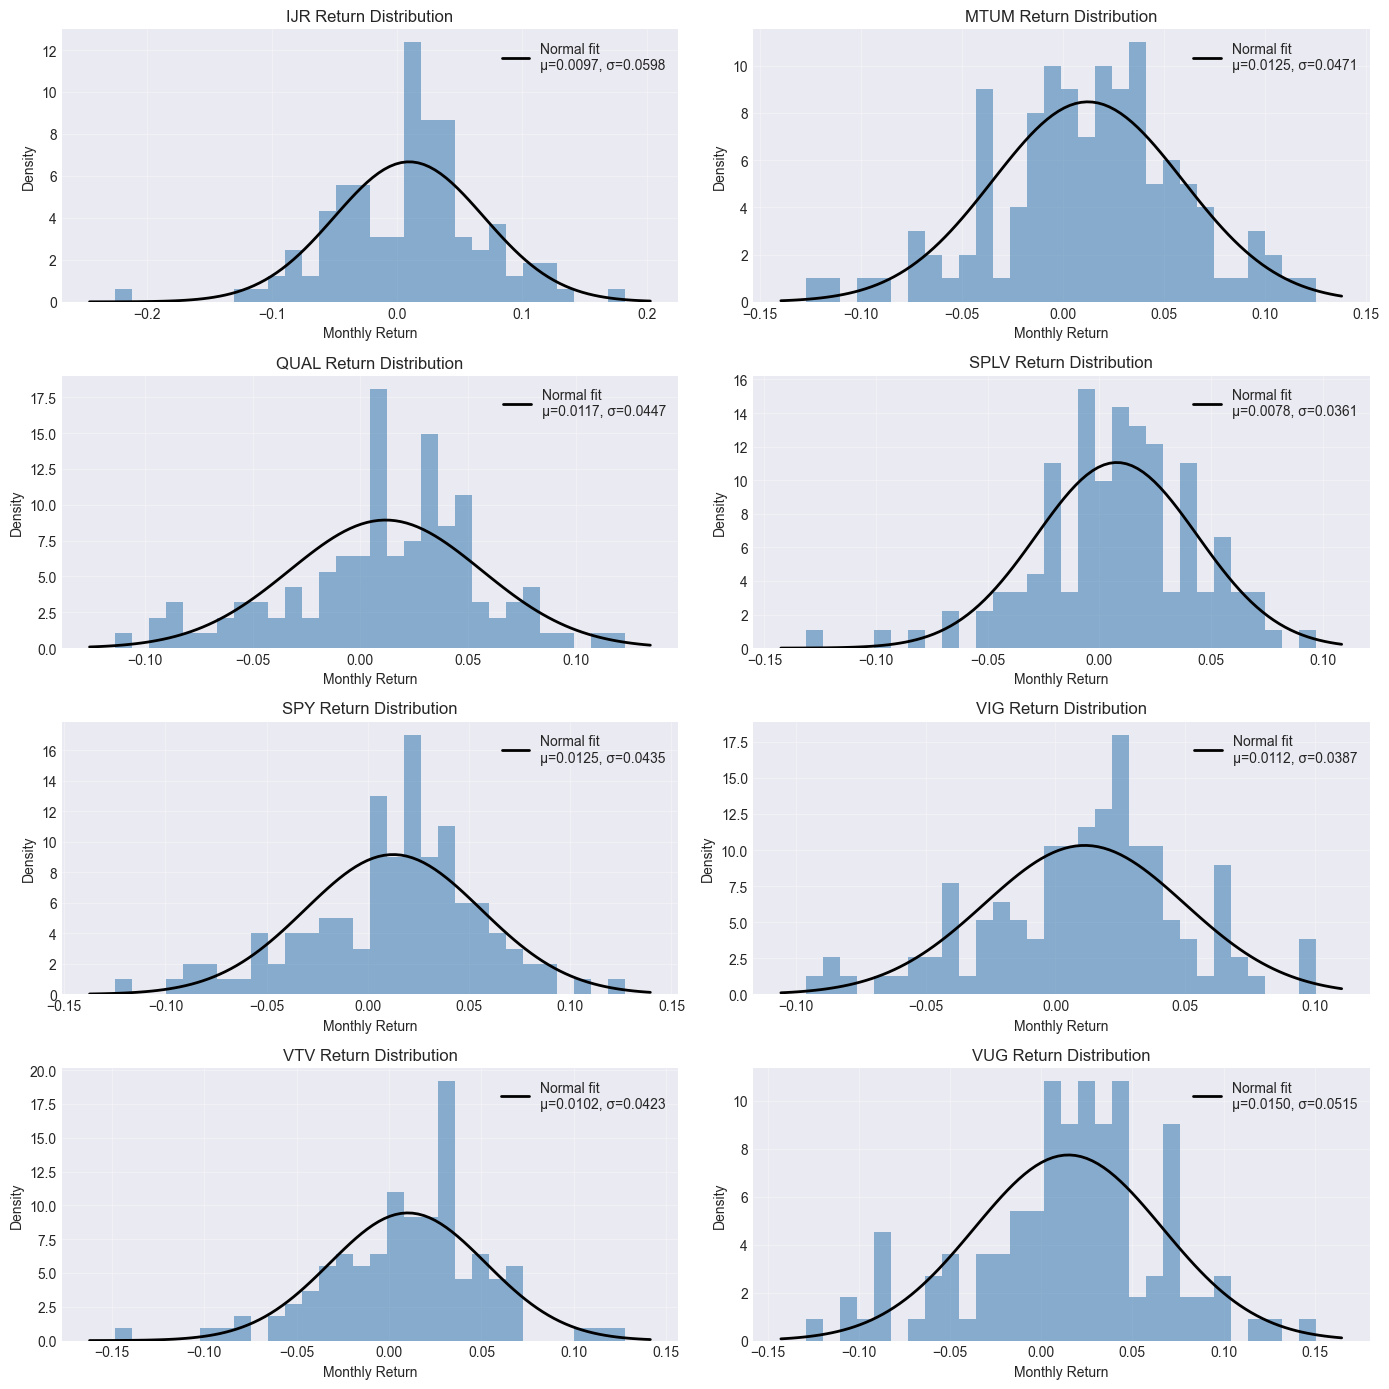

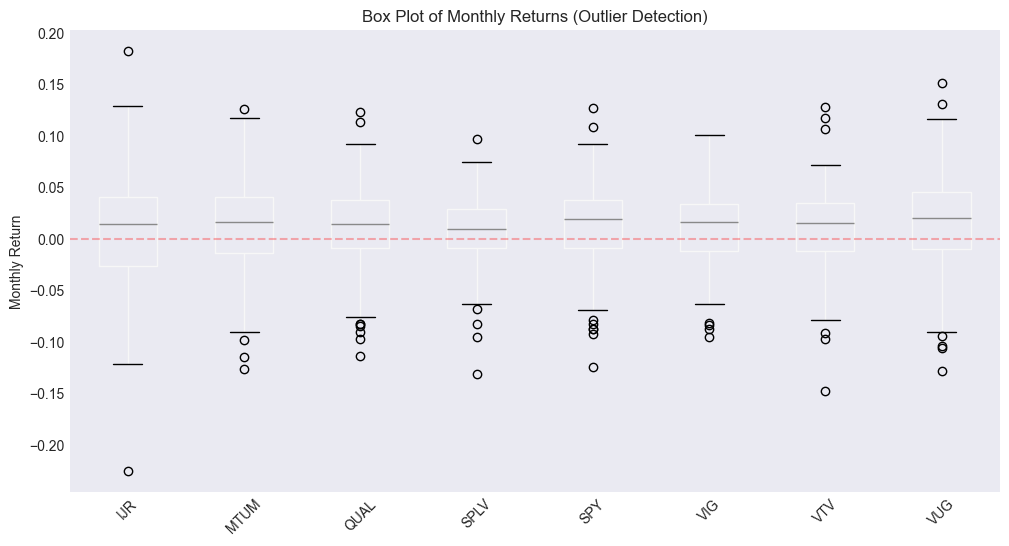

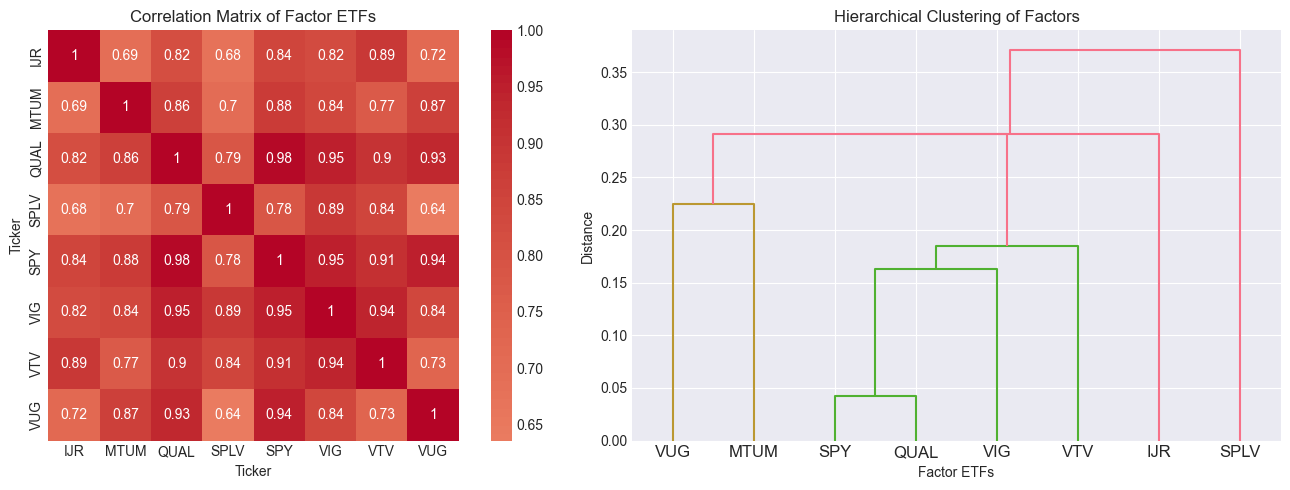

Stationarity Test Results (ADF & KPSS):


,ADF_Statistic,ADF_p-value,ADF_Stationary,KPSS_Statistic,KPSS_p-value,KPSS_Stationary
IJR,-11.9816,0.0000,True,0.0446,0.1000,True
MTUM,-11.4664,0.0000,True,0.0708,0.1000,True
QUAL,-9.4817,0.0000,True,0.0477,0.1000,True
SPLV,-10.1815,0.0000,True,0.0841,0.1000,True
SPY,-9.5142,0.0000,True,0.0635,0.1000,True
VIG,-9.9335,0.0000,True,0.0477,0.1000,True
VTV,-12.7609,0.0000,True,0.0431,0.1000,True
VUG,-11.6144,0.0000,True,0.0718,0.1000,True


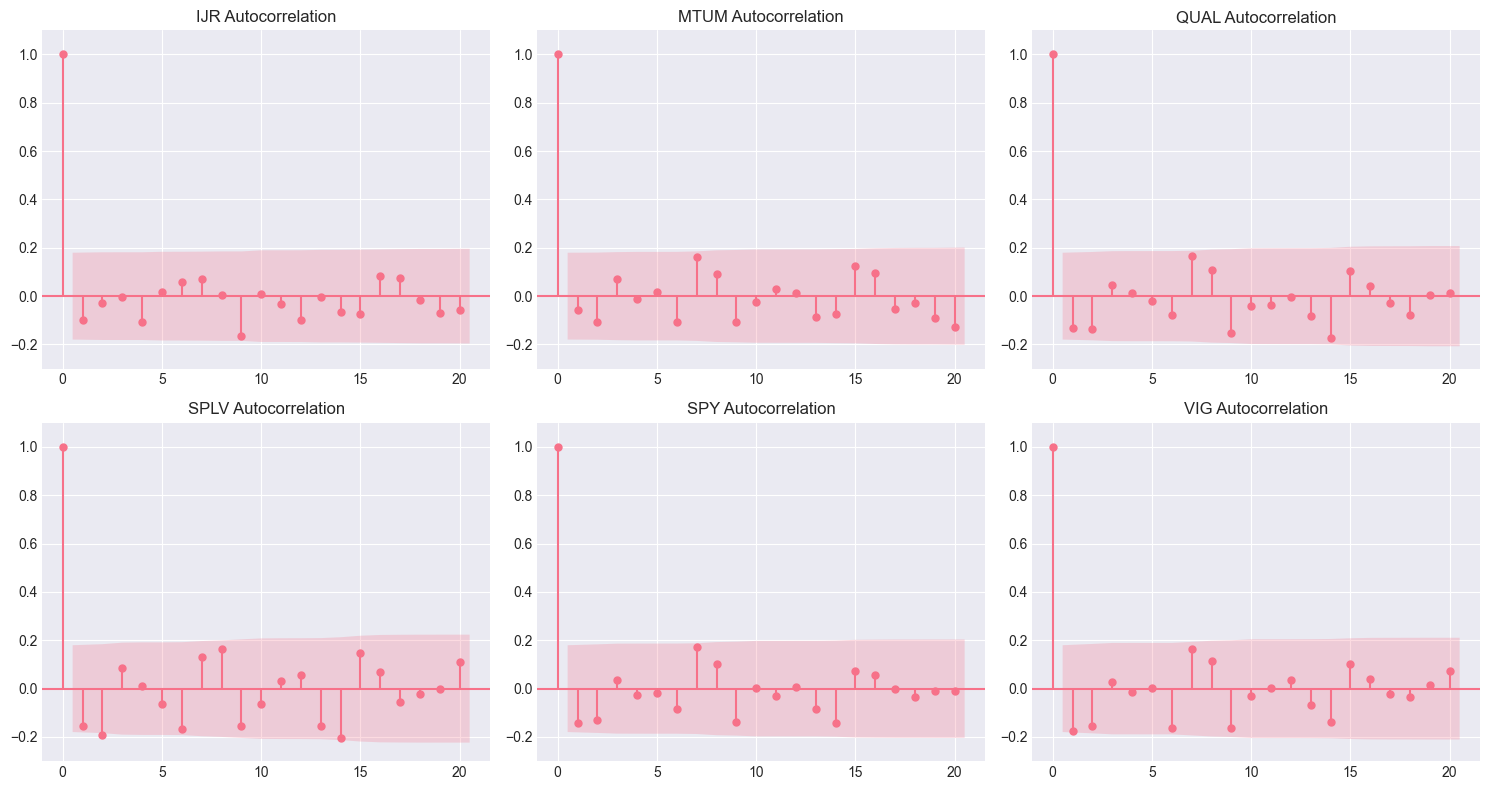

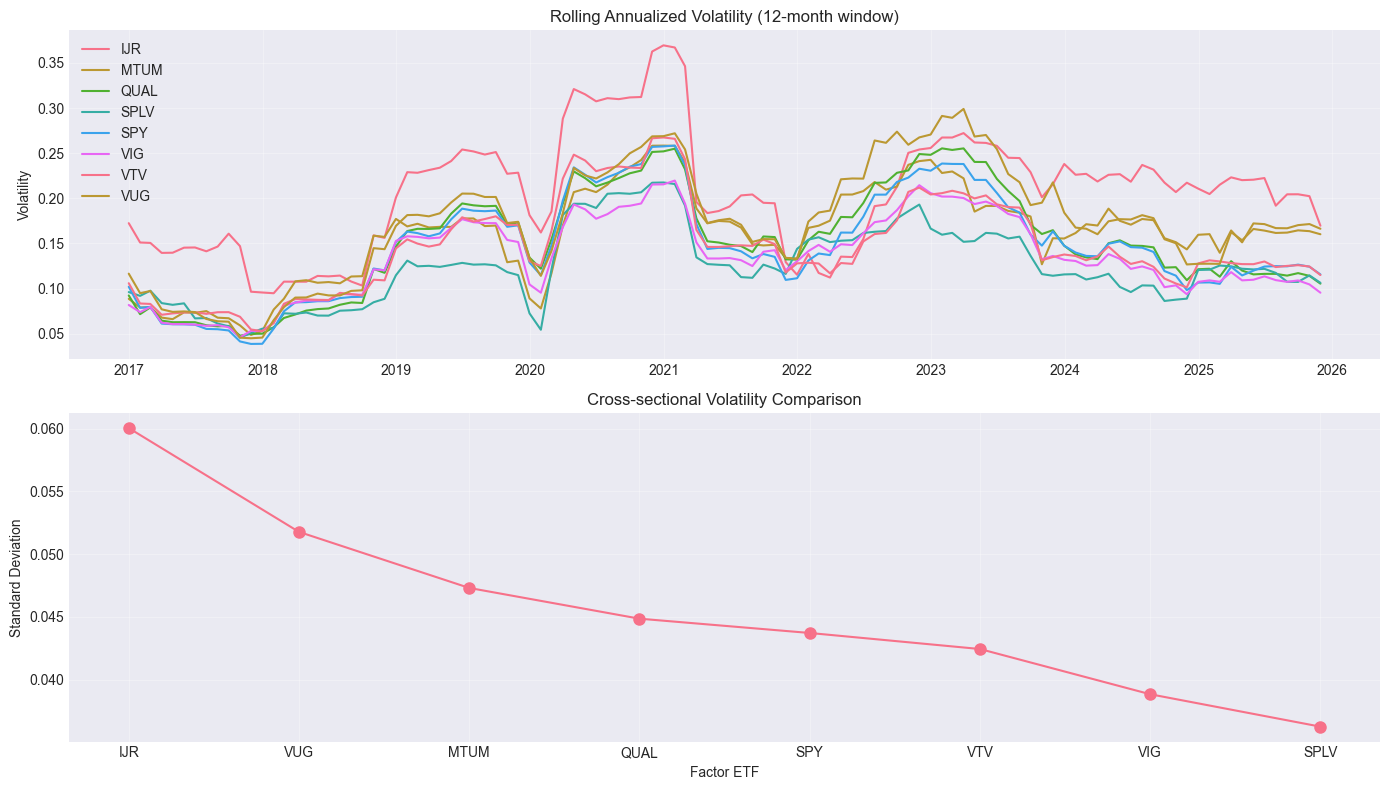

In [8]:
# 2. Exploratory Data Analysis & Financial Data Preparation

#  2.1 Statistics of Data: Measures of Centers, Spreads, Outliers

def compute_statistics(returns_df):
    """Compute statistics including outlier detection"""
    stats_dict = {}
    
    for col in returns_df.columns:
        series = returns_df[col].dropna()
        
        # Basic statistics
        stats = {
            'Mean': series.mean(),
            'Median': series.median(),
            'Std': series.std(),
            'Skewness': series.skew(),
            'Kurtosis': series.kurtosis(),
            'Min': series.min(),
            'Max': series.max(),
            'IQR': series.quantile(0.75) - series.quantile(0.25)
        }
        
        # Outlier detection using IQR method
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = series[(series < lower_bound) | (series > upper_bound)]
        
        stats['Outlier_Count'] = len(outliers)
        stats['Outlier_Pct'] = len(outliers) / len(series) * 100
        
        # Jarque-Bera normality test
        from scipy.stats import jarque_bera
        jb_stat, jb_pval = jarque_bera(series)
        stats['JB_Statistic'] = jb_stat
        stats['JB_p-value'] = jb_pval
        
        stats_dict[col] = stats
    
    return pd.DataFrame(stats_dict).T

# Compute comprehensive statistics
print("Statistics for Factor ETFs:")
stats_df = compute_statistics(monthly_returns)
display(stats_df)

 
#  2.2 Visualization: Histograms, Density & Box Plots

# Adjust subplot arrangement based on number of assets
n_assets = len(monthly_returns.columns)
n_rows = (n_assets + 1) // 2  # Ceiling division
fig, axes = plt.subplots(n_rows, 2, figsize=(14, n_rows * 3.5))

# Flatten axes for easy iteration
axes_flat = axes.flatten() if n_rows > 1 else [axes] if isinstance(axes, np.ndarray) else [axes]

# Histograms with density plots
for idx, col in enumerate(monthly_returns.columns):
    if idx < len(axes_flat):
        ax = axes_flat[idx]
        ax.hist(monthly_returns[col].dropna(), bins=30, density=True, alpha=0.6, color='steelblue')
        
        # Add normal distribution overlay
        from scipy.stats import norm
        mu, std = norm.fit(monthly_returns[col].dropna())
        xmin, xmax = ax.get_xlim()
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, mu, std)
        ax.plot(x, p, 'k', linewidth=2, label=f'Normal fit\nμ={mu:.4f}, σ={std:.4f}')
        
        ax.set_title(f'{col} Return Distribution')
        ax.set_xlabel('Monthly Return')
        ax.set_ylabel('Density')
        ax.legend()
        ax.grid(True, alpha=0.3)

for idx in range(len(monthly_returns.columns), len(axes_flat)):
    axes_flat[idx].set_visible(False)

plt.tight_layout()
plt.show()

# Box plot for outlier visualization
fig, ax = plt.subplots(figsize=(12, 6))
monthly_returns.boxplot(ax=ax, grid=False)
ax.set_title('Box Plot of Monthly Returns (Outlier Detection)')
ax.set_ylabel('Monthly Return')
ax.axhline(y=0, color='r', linestyle='--', alpha=0.3)
plt.xticks(rotation=45)
plt.show()

 
#  2.3 Correlation Analysis and Covariance Matrix

# Calculate correlation matrix
corr_matrix = monthly_returns.corr()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Correlation heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, square=True, ax=axes[0])
axes[0].set_title('Correlation Matrix of Factor ETFs')

# Hierarchical clustering dendrogram
from scipy.cluster.hierarchy import dendrogram, linkage
linked = linkage(corr_matrix, 'single')
dendrogram(linked, orientation='top', 
           labels=corr_matrix.columns, 
           distance_sort='descending',
           ax=axes[1])
axes[1].set_title('Hierarchical Clustering of Factors')
axes[1].set_xlabel('Factor ETFs')
axes[1].set_ylabel('Distance')

plt.tight_layout()
plt.show()

 
#  2.4 Temporal Structure Analysis: Stationarity Tests

def test_stationarity(timeseries, alpha=0.05):
    """Perform ADF and KPSS stationarity tests"""
    results = {}
    
    # ADF Test
    adf_result = adfuller(timeseries.dropna())
    results['ADF_Statistic'] = adf_result[0]
    results['ADF_p-value'] = adf_result[1]
    results['ADF_Stationary'] = adf_result[1] < alpha
    
    # KPSS Test
    kpss_result = kpss(timeseries.dropna(), regression='c')
    results['KPSS_Statistic'] = kpss_result[0]
    results['KPSS_p-value'] = kpss_result[1]
    results['KPSS_Stationary'] = kpss_result[1] > alpha
    
    return pd.Series(results)

# Test stationarity for each factor
stationarity_results = pd.DataFrame()
for col in monthly_returns.columns:
    stationarity_results[col] = test_stationarity(monthly_returns[col])

print("Stationarity Test Results (ADF & KPSS):")
display(stationarity_results.T)

 
#  2.5 Autocorrelation Analysis

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for idx, col in enumerate(monthly_returns.columns[:6]):
    from statsmodels.graphics.tsaplots import plot_acf
    plot_acf(monthly_returns[col].dropna(), lags=20, ax=axes[idx], alpha=0.05)
    axes[idx].set_title(f'{col} Autocorrelation')
    axes[idx].set_ylim([-0.3, 1.1])

plt.tight_layout()
plt.show()

 
#  2.6 Volatility Clustering and Long Memory

# Calculate rolling volatility
rolling_vol = monthly_returns.rolling(window=12).std() * np.sqrt(12)

fig, axes = plt.subplots(2, 1, figsize=(14, 8))
axes[0].plot(rolling_vol)
axes[0].set_title('Rolling Annualized Volatility (12-month window)')
axes[0].set_ylabel('Volatility')
axes[0].legend(rolling_vol.columns, loc='upper left')
axes[0].grid(True, alpha=0.3)

# Volatility autocorrelation
axes[1].plot(monthly_returns.std().sort_values(ascending=False), 'o-', markersize=8)
axes[1].set_title('Cross-sectional Volatility Comparison')
axes[1].set_ylabel('Standard Deviation')
axes[1].set_xlabel('Factor ETF')
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 3. Feature Engineering

Financial time series demand domain-specific features that capture key dynamics like momentum, mean reversion, and volatility regimes. The FinancialFeatureEngineer class constructs such features with careful time alignment to prevent look-ahead bias. Using expanding window calculations, it ensures that only data available up to a specific point in the past is used for each prediction, a practice which is essential for realistic backtesting and live deployment. Specifically, every feature is derived solely from information up to period t-2, meaning predictions are based on data two periods prior to the target. This intentional information gap mirrors real-world decision-making, where future data is never accessible. The expanding window method maximizes historical data usage while preserving temporal integrity. To detect volatility regimes, the system compares current volatility against its historical median rather than its mean as median is resistant to outliers. This approach builds a more robust detector that is less influenced by extreme outliers—particularly important during market crises, when volatility can surge unpredictably. Additionally, computing autocorrelation directly enables proper handling of edge cases and maintains consistency with the expanding window framework.

**Feature importance analysis**:
RandomForestClassifier feature importance analysis revealed varying predictive contributions across engineered features, with lagged returns from momentum and low-volatility factors demonstrating the highest importance scores. The top-performing features included IJR_lag3 (0.0563), MTUM_lag3 (0.0563), and VUG_lag1 (0.0552), with momentum factor MTUM and low-volatility factor SPLV appearing in multiple lags (MTUM_lag1: 0.0526, SPLV_lag2: 0.0536, SPLV_lag1: 0.0489, SPLV_lag3: 0.0483). While simple lagged returns alone provided some predictive power, the comprehensive feature engineering framework captured more nuanced market dynamics. These results highlight the advantage of ensemble methods like Random Forest that can capture non-linear relationships and feature interactions, which are essential for factor timing in financial markets.

In [9]:
# 3. Feature Engineering Framework

class FinancialFeatureEngineer:
    """Comprehensive feature engineering for financial time series"""
    
    def __init__(self, lookback_periods=[1, 3, 6, 12]):
        self.lookback_periods = lookback_periods
        self.epsilon = 1e-8 
        
    def create_technical_features(self, prices, date_index=None):
        """Create technical/price-based features"""
        if date_index is None:
            date_index = prices.index
        
        features = pd.DataFrame(index=date_index)
        returns = prices.pct_change()
        
        # Momentum features - using expanding windows up to t-2 to avoid look-ahead
        for period in self.lookback_periods:
            momentum_values = []
            for i in range(len(prices)):
                if i >= period + 1:  # Need period+1 for pct_change
                    # Use prices up to i-2 for calculation 
                    start_idx = max(0, i - period - 2)
                    past_prices = prices.iloc[start_idx:i-2]
                    if len(past_prices) >= 2:
                        momentum = past_prices.iloc[-1] / past_prices.iloc[0] - 1
                    else:
                        momentum = 0
                else:
                    momentum = 0
                momentum_values.append(momentum)
            
            features[f'momentum_{period}m'] = momentum_values
            
            # Volatility - calculated on past returns only using expanding window
            vol_values = []
            for i in range(len(returns)):
                if i >= period:
                    # Use returns up to i-2 
                    past_returns = returns.iloc[max(0, i-period-1):i-2]
                    if len(past_returns) > 1:
                        vol = past_returns.std() * np.sqrt(12)
                    else:
                        vol = 0
                else:
                    vol = 0
                vol_values.append(vol)
            
            features[f'volatility_{period}m'] = vol_values
        
        # Mean reversion features with proper expanding window
        zscore_values = []
        for i in range(len(prices)):
            if i >= 12:
                # Use prices up to i-2 
                past_prices = prices.iloc[max(0, i-13):i-2]
                if len(past_prices) > 1 and past_prices.std() > 0:
                    zscore = (prices.iloc[i-2] - past_prices.mean()) / past_prices.std()
                else:
                    zscore = 0
            else:
                zscore = 0
            zscore_values.append(zscore)
        
        features['zscore_12m'] = zscore_values
        
        # Volatility regime features - using expanding window up to t-2
        vol_series = []
        vol_regime = []
        
        for i in range(len(returns)):
            if i >= 12:
                # Calculate volatility using returns up to i-2
                past_returns = returns.iloc[max(0, i-13):i-2]
                if len(past_returns) > 1:
                    current_vol = past_returns.std() * np.sqrt(12)
                    
                    # Calculate historical median using returns up to i-3
                    if i >= 24:
                        hist_returns = returns.iloc[max(0, i-25):i-3]
                        if len(hist_returns) > 1:
                            hist_vol = hist_returns.std() * np.sqrt(12)
                            # Use expanding median of historical volatility
                            if i > 25:
                                all_hist_vols = []
                                for j in range(13, i-2):
                                    hist_window = returns.iloc[max(0, j-13):j-2]
                                    if len(hist_window) > 1:
                                        all_hist_vols.append(hist_window.std() * np.sqrt(12))
                                hist_median = np.median(all_hist_vols) if all_hist_vols else 0
                            else:
                                hist_median = hist_vol
                        else:
                            hist_median = 0
                    else:
                        hist_median = 0
                    
                    vol_series.append(current_vol)
                    vol_regime.append(1 if current_vol > hist_median else 0)
                else:
                    vol_series.append(0)
                    vol_regime.append(0)
            else:
                vol_series.append(0)
                vol_regime.append(0)
        
        features['vol_regime'] = vol_regime
        
        # Support/resistance with expanding window
        distance_to_high = []
        distance_to_low = []
        
        for i in range(len(prices)):
            if i >= 52:
                # Use prices up to i-2 
                past_prices = prices.iloc[max(0, i-53):i-2]
                if len(past_prices) > 0:
                    rolling_high = past_prices.max()
                    rolling_low = past_prices.min()
                    current_price = prices.iloc[i-2] if i > 1 else prices.iloc[0]
                    
                    if rolling_high > 0:
                        dist_high = (current_price - rolling_high) / rolling_high
                    else:
                        dist_high = 0
                    
                    if rolling_low > 0:
                        dist_low = (current_price - rolling_low) / rolling_low
                    else:
                        dist_low = 0
                else:
                    dist_high = 0
                    dist_low = 0
            else:
                dist_high = 0
                dist_low = 0
            
            distance_to_high.append(dist_high)
            distance_to_low.append(dist_low)
        
        features['distance_to_high'] = distance_to_high
        features['distance_to_low'] = distance_to_low
        
        # Set index properly
        features.index = date_index
        return features.dropna()
    
    def create_statistical_features(self, returns, date_index=None):
        """Create statistical features"""
        if date_index is None:
            date_index = returns.index
        
        features = pd.DataFrame(index=date_index)
        
        # Higher moment features with expanding windows
        skewness_values = []
        kurtosis_values = []
        
        for i in range(len(returns)):
            if i >= 12:
                # Use returns up to i-2 
                past_returns = returns.iloc[max(0, i-13):i-2]
                if len(past_returns) > 2:
                    skewness_values.append(past_returns.skew())
                    kurtosis_values.append(past_returns.kurtosis())
                else:
                    skewness_values.append(0)
                    kurtosis_values.append(0)
            else:
                skewness_values.append(0)
                kurtosis_values.append(0)
        
        features['skewness_12m'] = skewness_values
        features['kurtosis_12m'] = kurtosis_values
        
        # Risk metrics calculated on past data only
        var_values = []
        cvar_values = []
        
        for i in range(len(returns)):
            if i >= 12:
                # Use returns up to i-2 
                past_returns = returns.iloc[max(0, i-13):i-2]
                if len(past_returns) >= 5:
                    var_95 = np.percentile(past_returns, 5)
                    losses_below_var = past_returns[past_returns <= var_95]
                    if len(losses_below_var) > 0:
                        cvar_95 = losses_below_var.mean()
                    else:
                        cvar_95 = 0
                else:
                    var_95 = 0
                    cvar_95 = 0
            else:
                var_95 = 0
                cvar_95 = 0
            
            var_values.append(var_95)
            cvar_values.append(cvar_95)
        
        features['var_95'] = var_values
        features['cvar_95'] = cvar_values
        
        # Autocorrelation features on past data
        autocorr_1_values = []
        autocorr_3_values = []
        
        for i in range(len(returns)):
            if i >= 12:
                # Use returns up to i-2 
                past_returns = returns.iloc[max(0, i-13):i-2]
                if len(past_returns) > 3:
                    # Calculate autocorrelation manually
                    series = pd.Series(past_returns.values)
                    if series.std() > 0:
                        mean = series.mean()
                        var = series.var()
                        
                        # Lag 1 autocorrelation
                        if len(series) > 1:
                            lag1_cov = ((series.iloc[1:] - mean) * (series.iloc[:-1] - mean)).mean()
                            autocorr_1 = lag1_cov / var if var > 0 else 0
                        else:
                            autocorr_1 = 0
                        
                        # Lag 3 autocorrelation
                        if len(series) > 3:
                            lag3_cov = ((series.iloc[3:] - mean) * (series.iloc[:-3] - mean)).mean()
                            autocorr_3 = lag3_cov / var if var > 0 else 0
                        else:
                            autocorr_3 = 0
                    else:
                        autocorr_1 = 0
                        autocorr_3 = 0
                else:
                    autocorr_1 = 0
                    autocorr_3 = 0
            else:
                autocorr_1 = 0
                autocorr_3 = 0
            
            autocorr_1_values.append(autocorr_1)
            autocorr_3_values.append(autocorr_3)
        
        features['autocorr_1'] = autocorr_1_values
        features['autocorr_3'] = autocorr_3_values
        
        features.index = date_index
        return features.dropna()

feature_engineer = FinancialFeatureEngineer()

# Create comprehensive feature set for SPY
spy_price = monthly_prices[benchmark]
spy_returns = monthly_returns[benchmark]
 
#  3.1 Feature Selection and Ranking
def select_features(X, y, k=10):
    """Feature selection using univariate methods"""

    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)
    scores = pd.DataFrame({
        'Feature': X.columns,
        'Importance': rf.feature_importances_
    }).sort_values('Importance', ascending=False)
    selected_features = scores.head(k)['Feature'].values

    
    return scores, selected_features

def create_proper_feature_target_data(returns_df, feature_lookback=3, predict_ahead=1):
    """Create dataset with proper target: factor with highest return next period"""
    X_list, y_list = [], []
    dates = returns_df.index
    
    for i in range(feature_lookback, len(dates) - predict_ahead):
        # Features: lagged returns from t-1 to t-feature_lookback 
        features = []
        valid_features = True
        
        for lag in range(1, feature_lookback + 1):
            lag_idx = i - lag
            if lag_idx >= 0:
                features.extend(returns_df.iloc[lag_idx].values)
            else:
                valid_features = False
                break
        
        if not valid_features:
            continue
        
        # Target Factor with highest return in the next period (t+predict_ahead)
        target_idx = i + predict_ahead - 1  # -1 because we want to predict for next period
        if target_idx < len(returns_df):
            future_returns = returns_df.iloc[target_idx].values
            best_factor = np.argmax(future_returns)
            
            X_list.append(features)
            y_list.append(best_factor)
    
    feature_names = []
    for lag in range(1, feature_lookback+1):
        for factor in returns_df.columns:
            feature_names.append(f'{factor}_lag{lag}')
    
    return pd.DataFrame(X_list, columns=feature_names), np.array(y_list)

# Create dataset for feature selection with proper future prediction
factor_returns_only = monthly_returns[list(factor_etfs.values())]
X_features, y_target = create_proper_feature_target_data(factor_returns_only, predict_ahead=1)

# Perform feature selection
feature_scores, selected_feats = select_features(X_features, y_target,  k=15)
print("Top 15 Features by RF Classifier Selection:")
display(feature_scores.head(15))


Top 15 Features by RF Classifier Selection:


,Feature,Importance
18,IJR_lag3,0.0563
15,MTUM_lag3,0.0563
6,VUG_lag1,0.0552
10,SPLV_lag2,0.0536
1,MTUM_lag1,0.0526
16,QUAL_lag3,0.0516
12,VIG_lag2,0.0505
19,VIG_lag3,0.0498
3,SPLV_lag1,0.0489
17,SPLV_lag3,0.0483


## 4. Volatility-Based Market Regime Labelling

Market behavior is not uniform; it cycles between calm expansion and turbulent contraction. Volatility serves as a primary regime indicator, directly reflecting market uncertainty and shifts in risk appetite. Periods of high volatility (Regime 1) typically align with market stress, risk aversion, and a flight to safety, whereas low-volatility regimes (Regime 0) correspond to more confident, trend-following markets. The 70th percentile approach cleanly identifies these regimes without overfitting. The resulting binary classification is both intuitive and actionable. The distribution of regimes (64 months of low volatility versus 55 months of high volatility) provides balanced and sufficient data for training separate machine learning models tailored to each market state.

This method effectively pinpoints three major stress periods in recent history: the late-2018 policy concerns, the 2020 COVID crash, and the late-2022 inflation and rate shocks. The resulting visualization reveals a telling asymmetry: high-volatility regimes appear as brief but intense red zones, while low-volatility regimes form prolonged green expansions. This pattern confirms that the identified regimes reflect meaningful economic states, not mere statistical noise, making them relevant for factor rotation strategies. Because short crises and extended calm periods operate on fundamentally different logics, a two-stage factor selection approach is justified. To ensure long-term viability, the regime threshold is calculated using an expanding window. This allows the threshold to adapt dynamically as markets evolve, becoming inherently more or less volatile over decades which makes it a critical design for a strategy built to endure.


Creating regime labels with simple volatility-based detection...

Simple regime distribution:
0    64
1    55
Name: count, dtype: int64


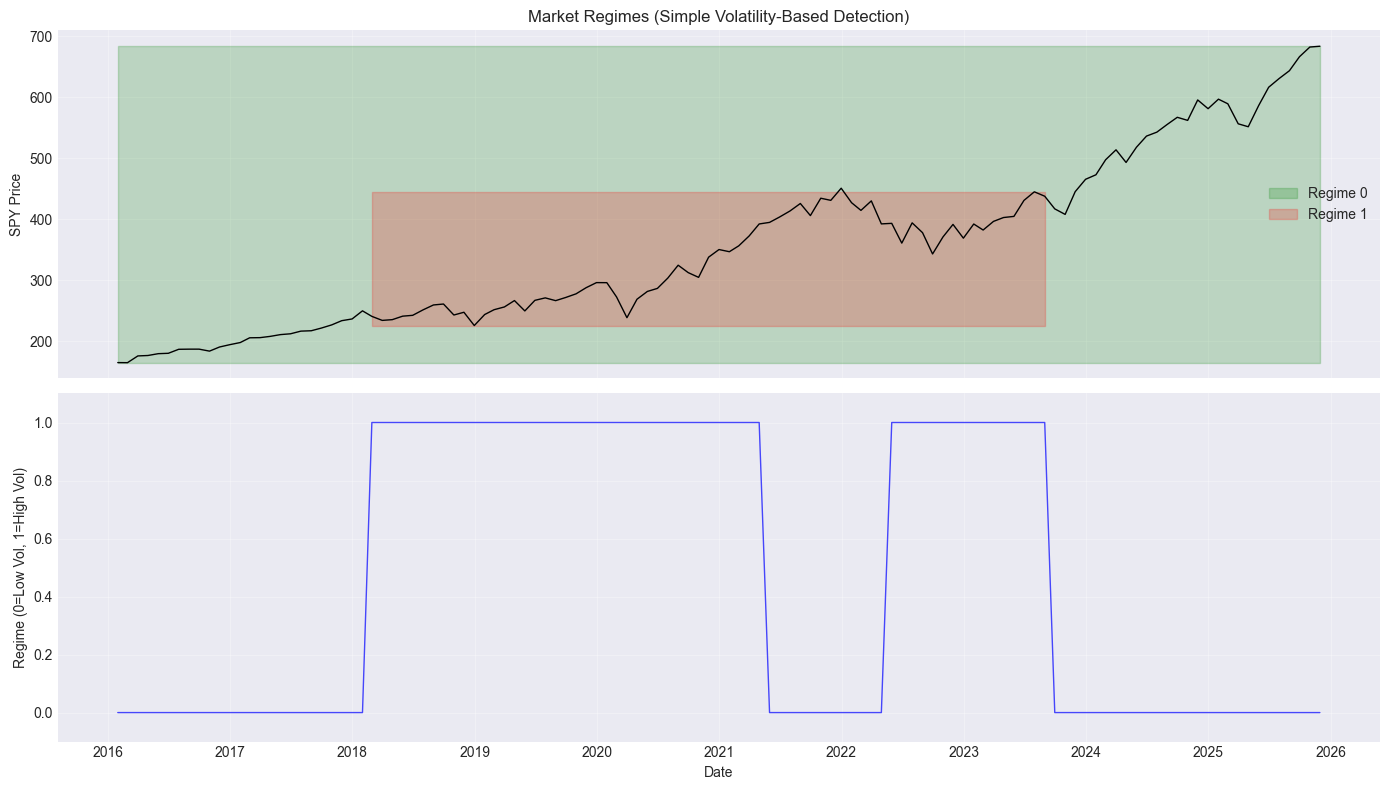

In [10]:
# 4. Volatility-Based Market Regime Detection

class RegimeDetector:
    """Volatility-based regime detection"""
    
    def __init__(self, lookback=12, threshold_percentile=70):
        self.lookback = lookback
        self.threshold_percentile = threshold_percentile
        
    def detect_regimes(self, prices, returns):
        """Detect regimes based on volatility percentiles"""
        dates = prices.index
        regime_labels = pd.Series(index=dates, dtype=int)
        
        # Calculate rolling volatility
        vol_values = []
        for i in range(len(returns)):
            if i >= self.lookback:
                # Use returns up to i-1 
                past_returns = returns.iloc[max(0, i-self.lookback):i]
                if len(past_returns) > 1:
                    vol = past_returns.std() * np.sqrt(12)
                else:
                    vol = 0
            else:
                vol = 0
            vol_values.append(vol)
        
        # Create Series for volatility 
        volatility_series = pd.Series(vol_values, index=returns.index)
        volatility_series = volatility_series.reindex(dates).fillna(0)
        
        # Calculate rolling volatility threshold using expanding window
        for i in range(len(dates)):
            if i >= self.lookback * 2:
                # Use volatility values up to i for threshold calculation
                historical_vol = volatility_series.iloc[:i]
                if len(historical_vol) >= 20:
                    threshold = np.percentile(historical_vol, self.threshold_percentile)
                    current_vol = volatility_series.iloc[i] if i < len(volatility_series) else 0
                    regime_labels.iloc[i] = 1 if current_vol > threshold else 0
                else:
                    regime_labels.iloc[i] = 0
            else:
                regime_labels.iloc[i] = 0
        
        # Fill any NaN values with 0
        regime_labels = regime_labels.fillna(0).astype(int)
        
        return regime_labels

# Create regime labels using simple volatility-based approach
print("Creating regime labels with simple volatility-based detection...")
simple_detector = RegimeDetector(lookback=12, threshold_percentile=70)
regime_labels_simple = simple_detector.detect_regimes(
    monthly_prices[benchmark],
    monthly_returns[benchmark]
)

# Ensure regime_labels_simple has the same index as monthly_returns
regime_labels_simple = regime_labels_simple.reindex(monthly_returns.index).fillna(0).astype(int)

print(f"\nSimple regime distribution:")
print(regime_labels_simple.value_counts().sort_index())

# Visualize the simple regimes
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

valid_dates = regime_labels_simple.index.intersection(monthly_prices[benchmark].index)
if len(valid_dates) > 0:
    aligned_prices = monthly_prices[benchmark].reindex(valid_dates)
    aligned_regimes = regime_labels_simple.reindex(valid_dates)
    
    colors = ['green', 'red']
    for regime in [0, 1]:
        regime_mask = aligned_regimes == regime
        regime_dates = aligned_regimes.index[regime_mask]
        if len(regime_dates) > 0:
            axes[0].fill_between(regime_dates, 
                               aligned_prices.loc[regime_dates].min(),
                               aligned_prices.loc[regime_dates].max(),
                               color=colors[regime], alpha=0.2, label=f'Regime {regime}')

    axes[0].plot(aligned_prices.index, aligned_prices.values, color='black', linewidth=1)
    axes[0].set_ylabel('SPY Price')
    axes[0].set_title('Market Regimes (Simple Volatility-Based Detection)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Plot regime distribution
    axes[1].plot(aligned_regimes.index, aligned_regimes.values, 
                color='blue', linewidth=1, alpha=0.7)
    axes[1].set_ylabel('Regime (0=Low Vol, 1=High Vol)')
    axes[1].set_xlabel('Date')
    axes[1].set_ylim([-0.1, 1.1])
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
else:
    print("Warning: No valid dates for visualization")



## 5. Machine Learning Model Training & Walk-Forward Backtesting

**Ensemble Model**:
The ensemble model employs a three-tiered complexity framework (low, medium, and high) designed to adapt dynamically to the available training data within each market regime. This adaptive methodology addresses a core challenge in financial machine learning: regime-specific datasets can vary dramatically in size. By matching model complexity to sample depth, the system avoids overfitting on small datasets and underfitting on richer ones, ensuring robustness across varying market conditions. Tree-based ensembles, such as Random Forests and XGBoost, were deliberately selected over linear models for several key reasons. First, they are capable of capturing the complex, non-linear relationships inherent in financial markets, which linear models often miss. Second, they automatically discover interactions between features—a critical advantage when univariate signals from lagged returns are weak. Third, ensembles average predictions across many trees, reducing overfitting and enhancing robustness to the substantial noise present in financial data. 

The selection strategy follows a hierarchical two-stage process. In Stage 1, momentum-based candidate screening narrows the prediction problem from seven factors down to three. This initial filter dramatically improves the machine learning model’s chances of success. Stage 2 then applies regime-specific ensemble models, training separate models for high and low volatility environments to tailor predictions to the prevailing market state.

**Walk-Forward with purging**:
A rigorous walk-forward testing framework simulates real-world deployment, with models retrained periodically as new data arrives. A two-month purge period between training and test sets prevents information leakage and eliminates look-ahead bias. This approach preserves temporal integrity and ensures predictions remain valid over time.


Throughout the testing period, the regime-specific datasets evolve: the low-volatility regime begins with 22 samples and grows to 55 by the end, while the high-volatility regime starts with 25 samples and eventually plateaus at 55. The system correctly responds to this growth by increasing model complexity as more data becomes available. The resulting prediction accuracy, measured against the three candidate factors, stands at 0.344 (34.4%). This performance below 50%, reflects the inherent difficulty of factor prediction in efficient markets and underscores the challenge of extracting a consistent signal from noisy and unpredictable financial data.


In [11]:
# 5. Ensemble Learning Framework for Factor Prediction

# 5.1 Ensemble Model Creation

def create_ensemble_models(complexity='medium'):
    """Create ensemble of classifiers with configurable complexity"""
    
    if complexity == 'low':
        # For small datasets
        models = {
            'RandomForest': RandomForestClassifier(
                n_estimators=30,
                max_depth=3,
                min_samples_split=10,
                min_samples_leaf=5,
                random_state=42,
                class_weight='balanced'
            ),
            'Logistic': LogisticRegression(
                max_iter=1000,
                C=0.5,
                random_state=42,
                class_weight='balanced'
            )
        }
    elif complexity == 'medium':
        # Balanced complexity
        models = {
            'RandomForest': RandomForestClassifier(
                n_estimators=50,
                max_depth=4,
                min_samples_split=8,
                min_samples_leaf=4,
                random_state=42,
                class_weight='balanced'
            ),
            'XGBoost': XGBClassifier(
                n_estimators=50,
                max_depth=3,
                learning_rate=0.1,
                reg_alpha=1.0,
                reg_lambda=1.0,
                random_state=42,
                eval_metric='mlogloss',
                use_label_encoder=False
            )
        }
    else:
        # Full ensemble
        models = {
            'RandomForest': RandomForestClassifier(
                n_estimators=100,
                max_depth=5,
                min_samples_split=5,
                min_samples_leaf=2,
                random_state=42,
                class_weight='balanced'
            ),
            'XGBoost': XGBClassifier(
                n_estimators=100,
                max_depth=4,
                learning_rate=0.1,
                reg_alpha=0.5,
                reg_lambda=0.5,
                random_state=42,
                eval_metric='mlogloss',
                use_label_encoder=False
            ),
            'AdaBoost': AdaBoostClassifier(
                n_estimators=50,
                learning_rate=0.5,
                random_state=42
            )
        }
    
    return models

 
# 5.2 Walk-Forward Backtesting Engine

class FactorIntelligenceStrategy:
    """Regime-Aware Factor Rotation Strategy with Walk-Forward Backtesting"""
    
    def __init__(self, returns_df, prices_df, regime_labels, 
                 train_months=48, feature_lookback=3, min_samples_per_regime=20,
                 top_k_factors=3, purge_months=2):
        self.returns_df = returns_df
        self.prices_df = prices_df
        self.regime_labels = regime_labels
        self.train_months = train_months
        self.feature_lookback = feature_lookback
        self.min_samples_per_regime = min_samples_per_regime
        self.top_k_factors = top_k_factors
        self.purge_months = purge_months
        self.all_factor_names = list(factor_etfs.values())
        self.n_all_factors = len(self.all_factor_names)
        
        # Add validation
        self.validate_config()
        self.validate_data_alignment()
        
    def validate_config(self):
        """Validate configuration parameters"""
        if self.top_k_factors > len(self.all_factor_names):
            raise ValueError(f"top_k_factors ({self.top_k_factors}) cannot exceed number of factors ({len(self.all_factor_names)})")
        if self.min_samples_per_regime < 10:
            print(f"Warning: min_samples_per_regime ({self.min_samples_per_regime}) is very low")
        if self.train_months < 24:
            print(f"Warning: train_months ({self.train_months}) may be insufficient")
        if self.purge_months < 1:
            print(f"Warning: purge_months ({self.purge_months}) should be >= 1")
            
    def validate_data_alignment(self):
        """Ensure all time series are properly aligned"""
        # Align regime labels with returns index
        common_idx = self.returns_df.index.intersection(self.regime_labels.index)
        if len(common_idx) < len(self.returns_df.index):
            print(f"Warning: {len(self.returns_df.index) - len(common_idx)} dates missing regime labels")
        self.regime_labels = self.regime_labels.reindex(self.returns_df.index)
        # Forward fill missing values, then backfill any remaining
        self.regime_labels = self.regime_labels.ffill().bfill().fillna(0).astype(int)
    
    def select_top_k_factors(self, current_date, lookback_months=6):
        """Select top K factors based on past data"""
        dates = self.returns_df.index
        current_idx = np.where(dates == current_date)[0][0]
        
        if current_idx < lookback_months + 2:
            return self.all_factor_names
        
        momentum_scores = {}
        for factor in self.all_factor_names:
            # Use data up to current_idx-2 to ensure no look-ahead
            start_idx = max(0, current_idx - lookback_months - 2)
            end_idx = current_idx - 2  # Exclude current and previous period
            
            if start_idx >= 0 and end_idx > start_idx:
                factor_returns = self.returns_df[factor].iloc[start_idx:end_idx]
                
                if len(factor_returns) > 1 and factor_returns.std() > 0:
                    momentum_score = factor_returns.mean() / factor_returns.std()
                else:
                    momentum_score = 0
            else:
                momentum_score = 0
            momentum_scores[factor] = momentum_score
        
        # Select top K factors
        sorted_factors = sorted(momentum_scores.items(), key=lambda x: x[1], reverse=True)
        top_factors = [factor for factor, score in sorted_factors[:self.top_k_factors]]
        
        return top_factors
    
    def prepare_training_data(self, current_date, predict_ahead=1, candidate_factors=None):
        """Prepare training data with proper time alignment and purging"""
        dates = self.returns_df.index
        current_idx = np.where(dates == current_date)[0][0]
        
        if candidate_factors is None:
            candidate_factors = self.all_factor_names
        
        # Training data ends before current period with purging.
        train_end_idx = current_idx - predict_ahead - self.purge_months - 1
        
        # Need minimum data for training
        min_needed = self.feature_lookback + predict_ahead + 10
        if train_end_idx < min_needed:
            return None, None, None
        
        train_dates = dates[:train_end_idx + 1]
        
        X_by_regime = {0: [], 1: []}
        y_by_regime = {0: [], 1: []}
        factor_to_idx = {factor: idx for idx, factor in enumerate(candidate_factors)}
        
        # Create features and targets with proper time alignment
        for t in range(self.feature_lookback, len(train_dates) - predict_ahead):
            feature_date = train_dates[t]
            
            # Get regime at time t (using only past data)
            if feature_date in self.regime_labels.index:
                current_regime = self.regime_labels.loc[feature_date]
                if pd.isna(current_regime):
                    continue
            else:
                continue
            
            # Features: lagged returns from t-1 to t-feature_lookback
            features = []
            valid = True
            
            for lag in range(1, self.feature_lookback + 1):
                lag_idx = t - lag
                if lag_idx >= 0:
                    lag_date = train_dates[lag_idx]
                    if lag_date in self.returns_df.index:
                        # Only include returns from candidate factors
                        for factor in candidate_factors:
                            features.append(self.returns_df.loc[lag_date, factor])
                    else:
                        valid = False
                        break
                else:
                    valid = False
                    break
            
            if not valid:
                continue
            
            # Which factor performed best in the future (t+predict_ahead)
            target_idx = t + predict_ahead
            if target_idx < len(train_dates):
                target_date = train_dates[target_idx]
                
                # Target: Which candidate factor had highest return at target_date
                returns_at_target = []
                for factor in candidate_factors:
                    if target_date in self.returns_df.index:
                        returns_at_target.append(self.returns_df.loc[target_date, factor])
                    else:
                        returns_at_target.append(0)
                
                if len(returns_at_target) > 0:
                    best_factor_idx = np.argmax(returns_at_target)
                else:
                    best_factor_idx = 0
            else:
                continue
            
            # Store in regime-specific containers
            regime_key = int(current_regime)
            X_by_regime[regime_key].append(features)
            y_by_regime[regime_key].append(best_factor_idx)
        
        # Filter regimes with sufficient data
        valid_regimes = {}
        for regime in [0, 1]:
            if len(X_by_regime[regime]) >= self.min_samples_per_regime:
                valid_regimes[regime] = {
                    'X': np.array(X_by_regime[regime]),
                    'y': np.array(y_by_regime[regime]),
                    'candidate_factors': candidate_factors
                }
        
        # Get current regime for prediction
        if current_date in self.regime_labels.index:
            current_regime = int(self.regime_labels.loc[current_date])
        else:
            current_regime = 0
        
        return valid_regimes, current_regime, candidate_factors
    
    def train_regime_model(self, X, y, regime):
        """Train a model for a specific regime with cross-validation"""
        if len(X) < 20:
            complexity = 'low'
        elif len(X) < 50:
            complexity = 'medium'
        else:
            complexity = 'high'
        
        models = create_ensemble_models(complexity)
        print(f"Training model for Regime {regime} with {len(X)} samples using {complexity} complexity ensemble.")
        
        # Train all models in the ensemble
        trained_models = {}
        fold_accuracies = {}
        
        if len(X) >= 20:
            tscv = TimeSeriesSplit(n_splits=min(3, len(X) // 5))
            
            for model_name, model in models.items():
                fold_scores = []
                
                for train_idx, val_idx in tscv.split(X):
                    X_train, X_val = X[train_idx], X[val_idx]
                    y_train, y_val = y[train_idx], y[val_idx]
                    
                    # Train and validate
                    model_copy = clone(model)
                    model_copy.fit(X_train, y_train)
                    y_pred = model_copy.predict(X_val)
                    fold_acc = accuracy_score(y_val, y_pred)
                    fold_scores.append(fold_acc)
                
                # Store average validation accuracy
                avg_acc = np.mean(fold_scores) if fold_scores else 0
                fold_accuracies[model_name] = avg_acc
                
                # Retrain on all data
                model.fit(X, y)
                trained_models[model_name] = model
        else:
            # For small datasets, just train on all data
            for model_name, model in models.items():
                model.fit(X, y)
                trained_models[model_name] = model
                fold_accuracies[model_name] = 0
        
        # Create ensemble prediction function
        class EnsembleModel:
            def __init__(self, models, accuracies):
                self.models = models
                self.accuracies = accuracies
                # Normalize accuracies for weighting
                total_acc = sum(accuracies.values())
                if total_acc > 0:
                    self.weights = {name: acc/total_acc for name, acc in accuracies.items()}
                else:
                    # Equal weights if no accuracy info
                    self.weights = {name: 1/len(models) for name in models.keys()}
            
            def predict(self, X):
                # Collect predictions from all models
                predictions = []
                weights = []
                
                for name, model in self.models.items():
                    pred = model.predict(X)
                    predictions.append(pred)
                    weights.append(self.weights[name])
                
                # Weighted voting
                predictions = np.array(predictions)
                final_pred = []
                
                for i in range(X.shape[0]):
                    # Get predictions for this sample from all models
                    sample_preds = predictions[:, i]
                    
                    # Weighted mode calculation
                    unique_preds = np.unique(sample_preds)
                    weighted_votes = []
                    
                    for pred_val in unique_preds:
                        weight_sum = sum(weights[j] for j in range(len(predictions)) 
                                    if predictions[j, i] == pred_val)
                        weighted_votes.append((weight_sum, pred_val))
                    
                    # Select prediction with highest weighted vote
                    weighted_votes.sort(reverse=True)
                    final_pred.append(weighted_votes[0][1])
                
                return np.array(final_pred)
            
            def predict_proba(self, X):
                # Average probabilities from all models
                all_probas = []
                
                for name, model in self.models.items():
                    if hasattr(model, 'predict_proba'):
                        proba = model.predict_proba(X)
                        all_probas.append(proba * self.weights[name])
                    else:
                        pred = model.predict(X)
                        n_classes = proba.shape[1] if all_probas else len(np.unique(y))
                        proba_one_hot = np.zeros((len(pred), n_classes))
                        for i, p in enumerate(pred):
                            proba_one_hot[i, int(p)] = 1.0
                        all_probas.append(proba_one_hot * self.weights[name])
                
                # Sum weighted probabilities
                final_proba = sum(all_probas)
                return final_proba
            
            def __getattr__(self, name):
                return getattr(next(iter(self.models.values())), name)
        
        ensemble = EnsembleModel(trained_models, fold_accuracies)
        
        if len(X) >= 20:
            train_acc = np.mean(list(fold_accuracies.values())) if fold_accuracies else 0
        else:
            train_acc = 0
        
        return ensemble, train_acc

    def predict_factor(self, current_date, regime_models, current_regime, candidate_factors):
        """Predict factor using past data"""
        dates = self.returns_df.index
        current_idx = np.where(dates == current_date)[0][0]
        
        # features using data up to current_idx-2
        features = []
        for lag in range(1, self.feature_lookback + 1):
            lag_idx = current_idx - lag - 1  # -1 to ensure its past data
            if lag_idx >= 0:
                lag_date = dates[lag_idx]
                if lag_date in self.returns_df.index:
                    for factor in candidate_factors:
                        features.append(self.returns_df.loc[lag_date, factor])
                else:
                    features.extend([0] * len(candidate_factors))
            else:
                features.extend([0] * len(candidate_factors))
        
        predicted_factor_idx = 0
        confidence = 0.5
        
        if current_regime in regime_models and len(features) == self.feature_lookback * len(candidate_factors):
            model_data = regime_models[current_regime]
            model = model_data['model']
            try:
                prediction = model.predict([features])[0]
                predicted_factor_idx = int(prediction)
                
                if predicted_factor_idx >= len(candidate_factors):
                    predicted_factor_idx = 0
                
                # Get confidence from ensemble
                if hasattr(model, 'predict_proba'):
                    probs = model.predict_proba([features])[0]
                    confidence = probs[predicted_factor_idx] if predicted_factor_idx < len(probs) else 0.5
            except:
                predicted_factor_idx = 0
                confidence = 0.5
        
        return predicted_factor_idx, confidence

    def run_walk_forward_backtest(self, predict_ahead=1):
        """Run walk-forward backtestt"""
        dates = self.returns_df.index
        
        # Add sufficient buffer for training, purging, and prediction
        total_needed = self.train_months + self.purge_months + predict_ahead + self.feature_lookback
        test_start_idx = total_needed
        
        if test_start_idx >= len(dates) - predict_ahead:
            test_start_idx = max(48, len(dates) // 3)
        
        print(f"\nWalk-forward backtest:")
        print(f"Total months needed for setup: {total_needed}")
        print(f"Training ends at: {dates[test_start_idx - self.purge_months - predict_ahead - 1].date()}")
        print(f"Testing starts at: {dates[test_start_idx].date()}")
        print(f"Purging period: {self.purge_months} months")
        
        results = {
            'Date': [],
            'Predicted_Regime': [],
            'Candidate_Factors': [],
            'Predicted_Factor': [],
            'Strategy_Return': [],
            'Benchmark_Return': [],
            'Actual_Best_Factor': [],
            'Confidence': []
        }
        
        for i in range(test_start_idx, len(dates) - predict_ahead):
            current_date = dates[i]
            
            # STAGE 1: Select top K factors using past data
            candidate_factors = self.select_top_k_factors(current_date)
            
            # STAGE 2: Prepare training data with purging
            regime_data, current_regime, used_candidates = self.prepare_training_data(
                current_date, predict_ahead, candidate_factors
            )
            
            # Train models for each regime
            regime_models = {}
            if regime_data:
                for regime, data in regime_data.items():
                    model, _ = self.train_regime_model(data['X'], data['y'], regime)
                    regime_models[regime] = {
                        'model': model,
                        'candidate_factors': data['candidate_factors']
                    }
            
            # Predict factor for next period
            predicted_factor_idx, confidence = self.predict_factor(
                current_date, regime_models, current_regime, candidate_factors
            )
            
            # Get actual returns for validation
            prediction_date_idx = i + predict_ahead
            if prediction_date_idx < len(dates):
                prediction_date = dates[prediction_date_idx]
                
                # Strategy return
                if predicted_factor_idx < len(candidate_factors):
                    predicted_factor = candidate_factors[predicted_factor_idx]
                    strategy_return = self.returns_df.loc[prediction_date, predicted_factor] if prediction_date in self.returns_df.index else 0
                else:
                    predicted_factor = candidate_factors[0]
                    strategy_return = self.returns_df.loc[prediction_date, candidate_factors[0]] if prediction_date in self.returns_df.index else 0
                
                # Benchmark return
                benchmark_return = self.returns_df.loc[prediction_date, benchmark] if (prediction_date in self.returns_df.index and benchmark in self.returns_df.columns) else 0
                
                # Best factor for accuracy calculation
                actual_returns = []
                for factor in candidate_factors:
                    if prediction_date in self.returns_df.index:
                        actual_returns.append(self.returns_df.loc[prediction_date, factor])
                    else:
                        actual_returns.append(0)
                
                if len(actual_returns) > 0:
                    actual_best_idx = np.argmax(actual_returns)
                    actual_best_factor = candidate_factors[actual_best_idx]
                else:
                    actual_best_factor = candidate_factors[0] if candidate_factors else "N/A"
            else:
                strategy_return = 0
                benchmark_return = 0
                actual_best_factor = candidate_factors[0] if candidate_factors else "N/A"
            
            # Store results
            results['Date'].append(current_date)
            results['Predicted_Regime'].append(current_regime)
            results['Candidate_Factors'].append(", ".join(candidate_factors))
            results['Predicted_Factor'].append(predicted_factor)
            results['Strategy_Return'].append(strategy_return)
            results['Benchmark_Return'].append(benchmark_return)
            results['Actual_Best_Factor'].append(actual_best_factor)
            results['Confidence'].append(confidence)
            
            if (i - test_start_idx) % 12 == 0:
                completed_pct = (i - test_start_idx) / max(1, (len(dates) - test_start_idx - predict_ahead)) * 100
                print(f"  Progress: {completed_pct:.1f}% (Date: {current_date.date()})")
        
        results_df = pd.DataFrame(results).set_index('Date')
        
        # Calculate accuracy
        if len(results_df) > 0:
            accuracy = (results_df['Predicted_Factor'] == results_df['Actual_Best_Factor']).mean()
            print(f"\nPrediction Accuracy (vs {self.top_k_factors} candidates): {accuracy:.3f}")
            print(f"Theoretical random accuracy: {1/self.top_k_factors:.3f}")
        
        return results_df

 

print("RUNNING STRATEGY")
print("="*80)
strategy = FactorIntelligenceStrategy(
    returns_df=monthly_returns,
    prices_df=monthly_prices,
    regime_labels=regime_labels_simple,
    train_months=48,
    feature_lookback=3,
    min_samples_per_regime=15,
    top_k_factors=3,
    purge_months=2
)
results = strategy.run_walk_forward_backtest(predict_ahead=1)



RUNNING STRATEGY

Walk-forward backtest:
Total months needed for setup: 54
Training ends at: 2020-03-31
Testing starts at: 2020-07-31
Purging period: 2 months
Training model for Regime 0 with 22 samples using medium complexity ensemble.
Training model for Regime 1 with 25 samples using medium complexity ensemble.
  Progress: 0.0% (Date: 2020-07-31)
Training model for Regime 0 with 22 samples using medium complexity ensemble.
Training model for Regime 1 with 26 samples using medium complexity ensemble.
Training model for Regime 0 with 22 samples using medium complexity ensemble.
Training model for Regime 1 with 27 samples using medium complexity ensemble.
Training model for Regime 0 with 22 samples using medium complexity ensemble.
Training model for Regime 1 with 28 samples using medium complexity ensemble.
Training model for Regime 0 with 22 samples using medium complexity ensemble.
Training model for Regime 1 with 29 samples using medium complexity ensemble.
Training model for Regime

## 6. Performance Analysis

The adaptive strategy achieved a 15.3% annual return, underperforming its benchmark's 16.7% return by 1.4% per year. More critically, it demonstrated inferior risk-adjusted performance, with a lower Sharpe ratio (0.74 vs 0.94), higher volatility (17.9% vs 15.7%), and deeper maximum drawdowns (-30% vs -24%). This indicates the machine learning framework introduced additional risk without adequate compensation. With a prediction accuracy of 34.4% when selecting among three candidate factors, the strategy barely exceeded the theoretical random guess rate of 33.3%. This marginal statistical edge proved insufficient to overcome trading costs, suggesting the models struggled to identify persistent factor leadership patterns from lagged return data alone. In multiple instances, such as March (-12.876%) and December (-9.414%) of 2021, the strategy selected the Growth factor (VUG) during low-volatility regimes when a defensive posture would have been preferable. Three of the five worst periods involved this pattern, suggesting the machine learning models may have been overfitting to recent momentum signals rather than accurately anticipating regime transitions.

However, the strategy successfully validated its core adaptive premise by demonstrating strong regime differentiation. It delivered an average return of 21.8% during high-volatility periods, compared to 11.5% in low-volatility regimes—a 10.3% performance gap representing the economic value of regime-aware investing. This confirms the framework effectively navigated turbulent markets while participating in calmer trends. An important nuance emerged in the analysis: despite the significant return differential, win rates remained nearly identical across regimes at 61%. This suggests that while the strategy captured more upside during market stress, it did not improve its ability to avoid losses, highlighting an area for refinement in defensive factor selection.

**Factor Selection Pattern**:
Analysis of factor selection patterns revealed a preference for offensive positioning. The Growth factor (VUG) dominated selections at 28%, followed by Momentum (MTUM) at 22%. Defensive factors such as Low Volatility (SPLV), Quality (QUAL), and Dividend Growth (VIG) received minimal allocation despite frequent appearance in the candidate pool, totaling only 25%. Contrary to expectations, the Small-Cap factor received a notable 14% allocation, indicating the model may have identified unique opportunities in this segment.

**Cost Simulation**:
To simulate real-world conditions, the analysis incorporated a 2% risk-free rate and a 0.5% transaction cost. The impact was severe: over 90 trades with a monthly turnover rate of 0.413, the strategy’s annual return fell from 15.295% to 9.698% after costs reduction of 5.597% that critically undermined economic viability.

**Risk Analysis**:
The strategy's Sortino Ratio of 1.21 and Calmar Ratio of 0.51 reflect adequate downside risk management but reveal a limited capacity to generate high returns relative to peak drawdowns. The negative Information Ratio of -0.11 confirmed the strategy failed to add value relative to its benchmark risk, implying it may have captured general market exposure rather than genuine factor-timing skill. Risk measures showed a 95% monthly Value at Risk of -7.6% and a Conditional VaR of -9.5%, indicating the severity of potential losses. The worst period was 3 months long.


In summary, while the adaptive framework successfully captured the economic value of regime differentiation, it was undermined by marginal prediction accuracy, a bias toward offensive factors, and excessive transaction costs. The result was a strategy that added risk without delivering sufficient compensated returns, failing to translate its structural insight into practical outperformance.

STRATEGY PERFORMANCE

Strategy Performance Summary:
Test Period: 2020-07-31 to 2025-10-31
Total Months: 64
Prediction Accuracy: 34.375%
Annual Return: 15.294% (Benchmark: 16.739%)
Annual Volatility: 17.921% (Benchmark: 15.704%)
Sharpe Ratio: 0.742 (Benchmark: 0.939)
Max Drawdown: -29.916% (Benchmark: -23.927%)
Win Rate: 60.938% (Benchmark: 65.625%)

Performance by Market Regime:
  Regime 0: 38 months, Avg Return: 11.451%, Win Rate: 60.526%
  Regime 1: 26 months, Avg Return: 21.840%, Win Rate: 61.538%

Factor Selection Distribution:
  VUG     :  18 times ( 28.1%)
  MTUM    :  14 times ( 21.9%)
  IJR     :   9 times ( 14.1%)
  SPLV    :   7 times ( 10.9%)
  VTV     :   7 times ( 10.9%)
  QUAL    :   6 times (  9.4%)
  VIG     :   3 times (  4.7%)


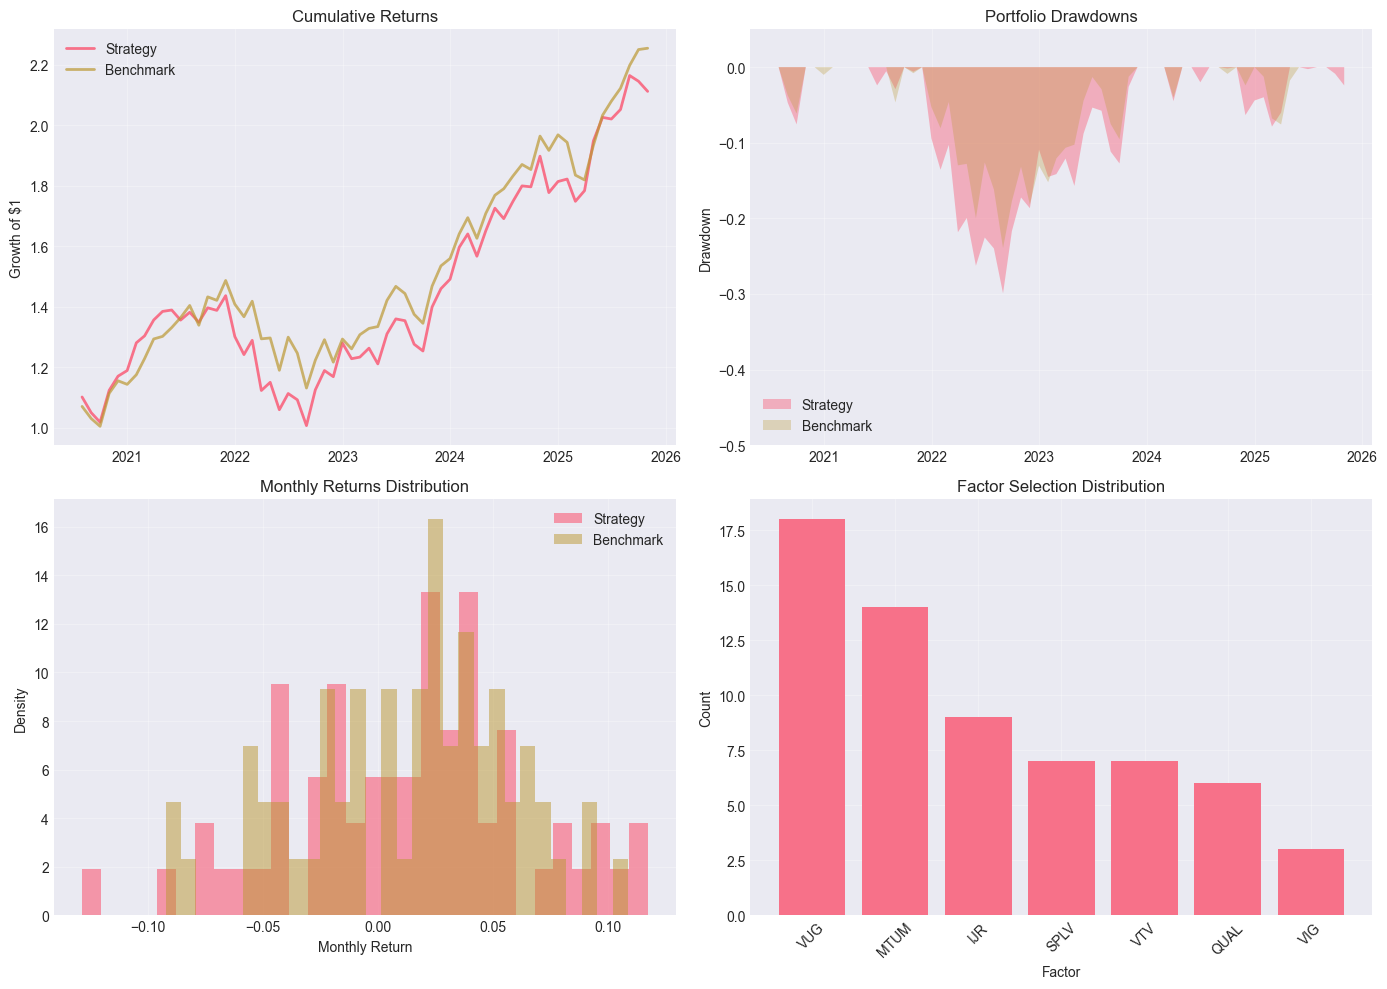

RISK ANALYSIS AND ROBUSTNESS CHECKS

Risk Metrics:
  Value at Risk (95%):      -7.592%
  Conditional VaR (95%):    -9.497%
  Sortino Ratio:            1.214
  Calmar Ratio:             0.511
  Information Ratio:        -0.110
  Max Consecutive Losses:   3 months

Worst Performing Periods:
  1. 2022-03-31: -12.876% (Regime: 0, Factor: VUG)
  2. 2021-12-31: -9.414% (Regime: 0, Factor: VUG)
  3. 2022-05-31: -7.886% (Regime: 1, Factor: VTV)
  4. 2022-08-31: -7.812% (Regime: 1, Factor: VTV)
  5. 2024-11-30: -6.344% (Regime: 0, Factor: SPLV)

Parameter Sensitivity Analysis:
  Feature Lookback:         3 months
  Training Period:          48 months
  Min Samples per Regime:   15
  Top K Factors (Stage 1):  3
  Purge Months:             2

Transaction Cost Impact (0.5% per trade):
  Total Round-trip Trades:   90
  Monthly Turnover Rate:     0.413
  Original Annual Return:     15.294%
  After-cost Annual Return:   9.698%
  Cost Impact:                -5.597%
✓ No look-ahead bias detected

Key F

In [12]:
# 6. Performance Analysis

if len(results) > 0:
    print("STRATEGY PERFORMANCE")
    print("="*80)
    
    strategy_returns = results['Strategy_Return'].dropna()
    benchmark_returns = results['Benchmark_Return'].dropna()
    
    if len(strategy_returns) > 0 and len(benchmark_returns) > 0:
        # Calculate performance metrics
        strategy_cum = (1 + strategy_returns).cumprod()
        benchmark_cum = (1 + benchmark_returns).cumprod()
        
        strategy_total_return = strategy_cum.iloc[-1] - 1 if len(strategy_cum) > 0 else 0
        benchmark_total_return = benchmark_cum.iloc[-1] - 1 if len(benchmark_cum) > 0 else 0
        
        # Calculate years for annualization
        start_date = strategy_returns.index[0]
        end_date = strategy_returns.index[-1]
        years = (end_date - start_date).days / 365.25
        
        strategy_annual_return = (1 + strategy_total_return) ** (1 / years) - 1 if years > 0 else 0
        benchmark_annual_return = (1 + benchmark_total_return) ** (1 / years) - 1 if years > 0 else 0
        
        strategy_annual_vol = strategy_returns.std() * np.sqrt(12)
        benchmark_annual_vol = benchmark_returns.std() * np.sqrt(12)
        
        # Sharpe ratio
        risk_free_rate = 0.02
        strategy_sharpe = (strategy_annual_return - risk_free_rate) / strategy_annual_vol if strategy_annual_vol > 0 else 0
        benchmark_sharpe = (benchmark_annual_return - risk_free_rate) / benchmark_annual_vol if benchmark_annual_vol > 0 else 0
        
        # Maximum drawdown
        def calculate_max_drawdown(cum_returns):
            if len(cum_returns) == 0:
                return 0
            peak = cum_returns.expanding(min_periods=1).max()
            drawdown = (cum_returns - peak) / peak
            return drawdown.min()
        
        strategy_max_dd = calculate_max_drawdown(strategy_cum)
        benchmark_max_dd = calculate_max_drawdown(benchmark_cum)
        
        # Accuracy
        accuracy = (results['Predicted_Factor'] == results['Actual_Best_Factor']).mean()
        
        print(f"\nStrategy Performance Summary:")
        print(f"Test Period: {start_date.date()} to {end_date.date()}")
        print(f"Total Months: {len(strategy_returns)}")
        print(f"Prediction Accuracy: {accuracy:.3%}")
        print(f"Annual Return: {strategy_annual_return:.3%} (Benchmark: {benchmark_annual_return:.3%})")
        print(f"Annual Volatility: {strategy_annual_vol:.3%} (Benchmark: {benchmark_annual_vol:.3%})")
        print(f"Sharpe Ratio: {strategy_sharpe:.3f} (Benchmark: {benchmark_sharpe:.3f})")
        print(f"Max Drawdown: {strategy_max_dd:.3%} (Benchmark: {benchmark_max_dd:.3%})")
        print(f"Win Rate: {(strategy_returns > 0).mean():.3%} (Benchmark: {(benchmark_returns > 0).mean():.3%})")
        
        # Regime performance
        print(f"\nPerformance by Market Regime:")
        for regime in sorted(results['Predicted_Regime'].unique()):
            regime_mask = results['Predicted_Regime'] == regime
            if regime_mask.any():
                regime_returns = results.loc[regime_mask, 'Strategy_Return']
                regime_months = regime_mask.sum()
                regime_avg_return = regime_returns.mean() * 12
                regime_win_rate = (regime_returns > 0).mean()
                print(f"  Regime {regime}: {regime_months} months, Avg Return: {regime_avg_return:.3%}, Win Rate: {regime_win_rate:.3%}")
        
        # Factor selection distribution
        factor_counts = pd.Series(results['Predicted_Factor']).value_counts()
        print(f"\nFactor Selection Distribution:")
        for factor, count in factor_counts.items():
            pct = count / len(results) * 100
            print(f"  {factor:8}: {count:3d} times ({pct:5.1f}%)")
        
        # Plot results
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        # 1. Cumulative returns
        axes[0, 0].plot(strategy_cum.index, strategy_cum.values, label='Strategy', linewidth=2)
        axes[0, 0].plot(benchmark_cum.index, benchmark_cum.values, label='Benchmark', linewidth=2, alpha=0.7)
        axes[0, 0].set_title('Cumulative Returns')
        axes[0, 0].set_ylabel('Growth of $1')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # 2. Drawdowns
        strategy_peak = strategy_cum.expanding(min_periods=1).max()
        strategy_dd = (strategy_cum - strategy_peak) / strategy_peak
        benchmark_peak = benchmark_cum.expanding(min_periods=1).max()
        benchmark_dd = (benchmark_cum - benchmark_peak) / benchmark_peak
        
        axes[0, 1].fill_between(strategy_dd.index, strategy_dd.values, 0, alpha=0.5, label='Strategy')
        axes[0, 1].fill_between(benchmark_dd.index, benchmark_dd.values, 0, alpha=0.3, label='Benchmark')
        axes[0, 1].set_title('Portfolio Drawdowns')
        axes[0, 1].set_ylabel('Drawdown')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        axes[0, 1].set_ylim([-0.5, 0.05])
        
        # 3. Monthly returns distribution
        axes[1, 0].hist(strategy_returns, bins=30, alpha=0.7, label='Strategy', density=True)
        axes[1, 0].hist(benchmark_returns, bins=30, alpha=0.5, label='Benchmark', density=True)
        axes[1, 0].set_title('Monthly Returns Distribution')
        axes[1, 0].set_xlabel('Monthly Return')
        axes[1, 0].set_ylabel('Density')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        # 4. Factor selection distribution
        axes[1, 1].bar(factor_counts.index, factor_counts.values)
        axes[1, 1].set_title('Factor Selection Distribution')
        axes[1, 1].set_xlabel('Factor')
        axes[1, 1].set_ylabel('Count')
        axes[1, 1].tick_params(axis='x', rotation=45)
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

 
# 6.1 Risk Analysis and Robustness Checks 

if len(results) > 0 and 'Strategy_Return' in results.columns and len(results['Strategy_Return']) > 0:
    print("RISK ANALYSIS AND ROBUSTNESS CHECKS")
    print("="*80)
    
    strategy_returns = results['Strategy_Return'].dropna()
    
    if len(strategy_returns) > 0:
        # 1. Value at Risk (95%)
        var_95 = np.percentile(strategy_returns, 5)
        
        # 2. Conditional VaR (Expected Shortfall)
        cvar_95 = strategy_returns[strategy_returns <= var_95].mean() if len(strategy_returns[strategy_returns <= var_95]) > 0 else var_95
        
        # 3. Sortino Ratio (downside risk only)
        downside_returns = strategy_returns[strategy_returns < 0]
        if len(downside_returns) > 1:
            downside_vol = downside_returns.std() * np.sqrt(12)
        else:
            downside_vol = 0
            
        # Recalculate annual return for risk metrics
        if len(strategy_returns) >= 12:
            start_date = strategy_returns.index[0]
            end_date = strategy_returns.index[-1]
            years = (end_date - start_date).days / 365.25
            strategy_total_return = (1 + strategy_returns).prod() - 1
            strategy_annual_return = (1 + strategy_total_return) ** (1 / years) - 1 if years > 0 else 0
        else:
            strategy_annual_return = 0
        
        risk_free_rate = 0.02
        sortino_ratio = (strategy_annual_return - risk_free_rate) / downside_vol if downside_vol > 0 else 0
        
        # 4. Calmar Ratio
        strategy_cum = (1 + strategy_returns).cumprod()
        strategy_max_dd = calculate_max_drawdown(strategy_cum)
        calmar_ratio = strategy_annual_return / abs(strategy_max_dd) if strategy_max_dd != 0 else 0
        
        # 5. Information Ratio (vs benchmark)
        benchmark_returns = results['Benchmark_Return'].dropna()
        if len(benchmark_returns) > 0:
            excess_returns = strategy_returns - benchmark_returns
            if excess_returns.std() > 0:
                information_ratio = excess_returns.mean() / excess_returns.std() * np.sqrt(12)
            else:
                information_ratio = 0
        else:
            information_ratio = 0
        
        # 6. Maximum consecutive losses
        consecutive_losses = 0
        max_consecutive_losses = 0
        current_streak = 0
        
        for ret in strategy_returns:
            if ret < 0:
                current_streak += 1
                max_consecutive_losses = max(max_consecutive_losses, current_streak)
            else:
                current_streak = 0
        
        print(f"\nRisk Metrics:")
        print(f"  Value at Risk (95%):      {var_95:.3%}")
        print(f"  Conditional VaR (95%):    {cvar_95:.3%}")
        print(f"  Sortino Ratio:            {sortino_ratio:.3f}")
        print(f"  Calmar Ratio:             {calmar_ratio:.3f}")
        print(f"  Information Ratio:        {information_ratio:.3f}")
        print(f"  Max Consecutive Losses:   {max_consecutive_losses} months")
        
        # 7. Stress test: worst periods
        if len(strategy_returns) >= 5:
            print(f"\nWorst Performing Periods:")
            worst_periods = strategy_returns.nsmallest(5)
            for i, (date, ret) in enumerate(worst_periods.items(), 1):
                regime = results.loc[date, 'Predicted_Regime'] if date in results.index else "N/A"
                factor = results.loc[date, 'Predicted_Factor'] if date in results.index else "N/A"
                print(f"  {i}. {date.date()}: {ret:.3%} (Regime: {regime}, Factor: {factor})")
        
        # 8. Sensitivity to parameters
        print(f"\nParameter Sensitivity Analysis:")
        print(f"  Feature Lookback:         {strategy.feature_lookback} months")
        print(f"  Training Period:          {strategy.train_months} months")
        print(f"  Min Samples per Regime:   {strategy.min_samples_per_regime}")
        print(f"  Top K Factors (Stage 1):  {strategy.top_k_factors}")
        print(f"  Purge Months:             {strategy.purge_months}")
        
        # 9. Transaction cost simulation
        transaction_cost_pct = 0.005  # 0.5% per trade
        
        # Calculate turnover
        turnover_count = 0
        factor_history = []
        
        for i in range(len(results)):
            current_factor = results['Predicted_Factor'].iloc[i]
            factor_history.append(current_factor)
            
            if i > 0:
                if factor_history[i] != factor_history[i-1]:
                    turnover_count += 1
        
        total_trades = len(results)  # Initial positions
        total_round_trip_trades = total_trades + turnover_count  # Initial + rebalances
        
        # Calculate cost-adjusted returns
        cost_adjusted_values = [1.0]  # Start with $1
        current_factor = None
        
        for i in range(len(results)):
            if i < len(strategy_returns):
                ret = strategy_returns.iloc[i]
                current_date = strategy_returns.index[i]
                
                # Get current predicted factor
                if current_date in results.index:
                    new_factor = results.loc[current_date, 'Predicted_Factor']
                else:
                    new_factor = None
                
                # Apply transaction cost if changing factors
                if i > 0 and new_factor != current_factor and current_factor is not None:
                    cost_adjusted_values[-1] *= (1 - 2 * transaction_cost_pct)
                
                # Update current factor
                current_factor = new_factor
                
                # Apply return
                new_value = cost_adjusted_values[-1] * (1 + ret)
                cost_adjusted_values.append(new_value)
        
        cost_adjusted_cum = pd.Series(cost_adjusted_values[1:], index=strategy_returns.index)
        cost_adjusted_total_return = cost_adjusted_cum.iloc[-1] - 1 if len(cost_adjusted_cum) > 0 else 0
        
        # Annualize cost-adjusted return
        if len(strategy_returns) >= 12:
            years = (strategy_returns.index[-1] - strategy_returns.index[0]).days / 365.25
            cost_adjusted_annual_return = (1 + cost_adjusted_total_return) ** (1 / years) - 1 if years > 0 else 0
        else:
            cost_adjusted_annual_return = 0
        
        cost_impact = cost_adjusted_annual_return - strategy_annual_return
        
        print(f"\nTransaction Cost Impact (0.5% per trade):")
        print(f"  Total Round-trip Trades:   {total_round_trip_trades}")
        print(f"  Monthly Turnover Rate:     {turnover_count / max(1, len(results)-1):.3f}")
        print(f"  Original Annual Return:     {strategy_annual_return:.3%}")
        print(f"  After-cost Annual Return:   {cost_adjusted_annual_return:.3%}")
        print(f"  Cost Impact:                {cost_impact:.3%}")

 
# 6.2 Data Validation Function

def validate_no_lookahead(returns_df, features, predictions):
    """Validate that there's no look-ahead bias"""
    
    dates = returns_df.index
    issues_found = 0
    
    for i, pred_date in enumerate(predictions.index):
        pred_idx = np.where(dates == pred_date)[0][0]
        
        # Check that features only use data before prediction date
        if i > 0:
            feature_dates = features.index[:pred_idx]
            last_feature_date = feature_dates[-1] if len(feature_dates) > 0 else None
            
            if last_feature_date is not None and last_feature_date >= pred_date:
                print(f"ERROR: Feature date {last_feature_date.date()} >= Prediction date {pred_date.date()}")
                issues_found += 1
        
        if pred_idx + 1 < len(dates):
            target_date = dates[pred_idx + 1]
            if target_date <= pred_date:
                print(f"ERROR: Target date {target_date.date()} <= Prediction date {pred_date.date()}")
                issues_found += 1
    
    if issues_found == 0:
        print("✓ No look-ahead bias detected")
    else:
        print(f"✗ Found {issues_found} potential look-ahead issues")
    
    return issues_found

if len(results) > 0:
    validate_no_lookahead(monthly_returns, monthly_returns, results)


if len(results) > 0 and 'Strategy_Return' in results.columns and len(results['Strategy_Return']) > 0:
    # Calculate final metrics
    strategy_returns = results['Strategy_Return'].dropna()
    benchmark_returns = results['Benchmark_Return'].dropna()
    
    if len(strategy_returns) > 0 and len(benchmark_returns) > 0:
        # Recalculate for summary
        strategy_total_return = (1 + strategy_returns).prod() - 1
        benchmark_total_return = (1 + benchmark_returns).prod() - 1
        
        if len(strategy_returns) >= 12:
            years = (strategy_returns.index[-1] - strategy_returns.index[0]).days / 365.25
            strategy_annual_return = (1 + strategy_total_return) ** (1 / years) - 1 if years > 0 else 0
            benchmark_annual_return = (1 + benchmark_total_return) ** (1 / years) - 1 if years > 0 else 0
        else:
            strategy_annual_return = 0
            benchmark_annual_return = 0
        
        strategy_vol = strategy_returns.std() * np.sqrt(12)
        benchmark_vol = benchmark_returns.std() * np.sqrt(12)
        
        risk_free_rate = 0.02
        strategy_sharpe = (strategy_annual_return - risk_free_rate) / strategy_vol if strategy_vol > 0 else 0
        benchmark_sharpe = (benchmark_annual_return - risk_free_rate) / benchmark_vol if benchmark_vol > 0 else 0
        
        outperformance = strategy_annual_return - benchmark_annual_return
        risk_adjusted_outperformance = strategy_sharpe - benchmark_sharpe
        
        print(f"\nKey Findings:")
        print(f"1. Strategy vs Benchmark:")
        print(f"   • Annual Return: {'Outperformed' if outperformance > 0 else 'Underperformed'} by {abs(outperformance):.3%}")
        print(f"   • Risk-Adjusted: {'Better' if risk_adjusted_outperformance > 0 else 'Worse'} Sharpe ratio by {abs(risk_adjusted_outperformance):.3f}")
        
        # Get max drawdowns
        strategy_cum = (1 + strategy_returns).cumprod()
        benchmark_cum = (1 + benchmark_returns).cumprod()
        strategy_max_dd = calculate_max_drawdown(strategy_cum)
        benchmark_max_dd = calculate_max_drawdown(benchmark_cum)
        dd_difference = strategy_max_dd - benchmark_max_dd
        print(f"   • Maximum Drawdown: {'Lower' if dd_difference > 0 else 'Higher'} by {abs(dd_difference):.3%}")
        
        print(f"\n2. Strategy Characteristics:")
        print(f"   • Two-stage selection: Top {strategy.top_k_factors} factors -> ML selection")
        print(f"   • Walk-forward with purging: {strategy.purge_months} month purge between train/test")
        print(f"   • Active for {len(results)} months")
        print(f"   • Average prediction confidence: {results['Confidence'].mean():.3f}")
        print(f"   • Prediction accuracy: {(results['Predicted_Factor'] == results['Actual_Best_Factor']).mean():.3%}")
        
        print(f"\n3. Regime Effectiveness:")
        regime_0_mask = results['Predicted_Regime'] == 0
        regime_1_mask = results['Predicted_Regime'] == 1
        
        if regime_0_mask.any():
            regime_0_returns = results.loc[regime_0_mask, 'Strategy_Return']
            regime_0_perf = regime_0_returns.mean() * 12
            print(f"   • Regime 0 (Low Vol): {regime_0_mask.sum()} months, Avg return {regime_0_perf:.3%}")
        
        if regime_1_mask.any():
            regime_1_returns = results.loc[regime_1_mask, 'Strategy_Return']
            regime_1_perf = regime_1_returns.mean() * 12
            print(f"   • Regime 1 (High Vol): {regime_1_mask.sum()} months, Avg return {regime_1_perf:.3%}")

        # Final performance comparison
        print(f"FINAL PERFORMANCE COMPARISON")
        print("="*80)
        
        comparison_data = {
            'Metric': ['Annual Return', 'Annual Volatility', 'Sharpe Ratio', 
                       'Max Drawdown', 'Win Rate', 'Total Return'],
            'Strategy': [strategy_annual_return, strategy_vol, strategy_sharpe,
                         strategy_max_dd, 
                         (strategy_returns > 0).mean(), strategy_total_return],
            'Benchmark': [benchmark_annual_return, benchmark_vol, benchmark_sharpe,
                          benchmark_max_dd,
                          (benchmark_returns > 0).mean(), benchmark_total_return]
        }
        
        comparison_df = pd.DataFrame(comparison_data)
        
        # Calculate difference
        comparison_df['Difference'] = comparison_df['Strategy'] - comparison_df['Benchmark']
        
        print(comparison_df.to_string(index=False))
        
    else:
        print("\nInsufficient data for performance comparison.")
else:
    print("\nNo results available. Please check data and parameters.")


## 7. Conclusion

**Future Considerations**:
1. Add proper portfolio construction methodology, incorporating techniques like volatility targeting, position sizing, and the blending of complementary factors. This diversification at the portfolio level would smooth returns and mitigate the impact of any single incorrect factor prediction.
2. The model requires the integration of realistic trading and capacity constraints. Some key considerations include incorporating liquidity filters to ensure trades can be executed without excessive market impact, enforcing position limits to manage concentration risk, and modeling transaction costs more dynamically based on trade size and market conditions.
3. Add risk managament directly into the investment process. This involves moving beyond mere prediction to include mechanisms for stop-losses, maximum drawdown controls, and regime-aware volatility scaling. The goal is to systematically protect capital during adverse periods, directly addressing the strategy's weakness in defensive positioning and its tendency toward deep drawdowns.



